## Content <a id='content'></a>

[Introduction](#intro)

[Dataset](#dataset)

[Data preprocessing](#prep)

[Data Analysis](#da)

[Conclusions](#conclusions)

# Introduction <a id='intro'></a>

Me and my partners decided to open a small robot-run cafe in Los Angeles. The project is promising but expensive, so we want to try to attract investors. They are interested in the current market conditions—will we be able to maintain the success when the novelty of robot waiters wears off? So the task is to prepare some market research. To this end, we will employ open-source data on restaurants in LA. We will implement the following steps:

**1. Prepare the data.**

**2. Perform the analysis.**

**3. Finally, we will prepare a presentation.** 


The deliverable of this project is a PDF file presenting this research to investors.

# Dataset <a id='dataset'></a>

Data description
`rest_data` table:

- `object_name` — establishment name
- `chain` — chain establishment (TRUE/FALSE)
- `object_type` — establishment type
- `address` — address
- `number` — number of seats

# Data preprocessing <a id='prep'></a>

## Libraries

Let's load the libraries we might need:

In [ ]:
#pip install cufflinks

In [2]:
# Loading the libraries

import numpy as np
import pandas as pd
import datetime as dt

import re

import matplotlib.pyplot as plt # We will need this for visualisations
%matplotlib inline
import seaborn as sns

# Standard plotly imports
import plotly.graph_objs as go

# We can use Plotly directly with Pandas dataframes using another library named Cufflinks
from plotly.offline import iplot, init_notebook_mode# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

from scipy import stats as st # We will need this in case we want to make some statistical checks
import math as mth

# To filter out automatic comments on plots from Jupyter (not affecting the output)
import warnings
warnings.filterwarnings("ignore") 

[Back to Content](#content)

## File upload

We will use a `load()` function to avoid potential problems with the file pathes.

In [3]:
# function `load` for a csv load with try-except and a number of rows limit
def load(filename, sep = ','):
    """
    i=In addition to the file name, the function takes nrow parameter
    for a particular number of rows to load. If None, then the file is loaded fully.
    """
    try:
        df_raw = pd.read_csv(filename, sep = sep)
    except:
        df_raw = pd.read_csv('/'+filename, sep = sep)
    return df_raw

In [4]:
rest_data = load('datasets/rest_data_us.csv')

## Data overview <a id='data_overview'></a>

Let's look into the file:

In [5]:
rest_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9651 non-null   int64 
 1   object_name  9651 non-null   object
 2   address      9651 non-null   object
 3   chain        9648 non-null   object
 4   object_type  9651 non-null   object
 5   number       9651 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 2.4 MB


`rest_data_us.csv` has been read correctly; we can check whther it is better to cast `chain` and `object_type` into categorical variables; the `chain` variable has 3 missing values.

In [6]:
rest_data['chain'].value_counts()

False    5972
True     3676
Name: chain, dtype: int64

In [7]:
rest_data['object_type'].value_counts()

Restaurant    7255
Fast Food     1066
Cafe           435
Pizza          320
Bar            292
Bakery         283
Name: object_type, dtype: int64

In [8]:
rest_data[rest_data['chain'].isna()]

,id,object_name,address,chain,object_type,number
7408,19194,TAQUERIA LOS 3 CARNALES,5000 E WHITTIER BLVD,NaN,Restaurant,14
7523,19309,JAMMIN JIMMY'S PIZZA,1641 FIRESTONE BLVD,NaN,Pizza,1
8648,20434,THE LEXINGTON THEATER,129 E 3RD ST,NaN,Restaurant,35


Let's investigate how many of objects with similar names are presented in the dataframe.

In [9]:
rest_data['all_tageuria'] = rest_data['object_name'].str.findall('CARNA').astype('bool')

In [10]:
rest_data[rest_data['all_tageuria'] == True]

,id,object_name,address,chain,object_type,number,all_tageuria
6419,18205,TACOS LOS CARNALES,4370 S CENTRAL AVE,False,Fast Food,47,True
6624,18410,TACOS LOS 3 CARNALES,5000 WHITTIER BLVD,False,Fast Food,6,True
7408,19194,TAQUERIA LOS 3 CARNALES,5000 E WHITTIER BLVD,NaN,Restaurant,14,True
9616,21402,TACOS LOS 4 CARNALES,5000 WHITTIER BLVD,False,Fast Food,9,True


Hm... Looks like we have 3 objects with similar names at the same address. We can find one `Tacos Los 3 Carnales` [here](https://foursquare.com/v/los-3-carnales/55346444498e6ce7d0040b21) and it is a restaurant; thus we would better drop the those with `id` equal `19194` and `21402`.

In [11]:
rest_data = rest_data.drop([7408,9616])

Let's check the other two places.

In [12]:
rest_data['all_jimmy'] = rest_data['object_name'].str.findall('JIMMY').astype('bool')

In [13]:
rest_data[rest_data['all_jimmy'] == True]

,id,object_name,address,chain,object_type,number,all_tageuria,all_jimmy
3371,15157,JIMMY JOHN'S #2575,3150 WILSHIRE BLVD STE 118,True,Restaurant,29,False,True
5189,16975,JIMMY JOHN'S,600 W 7TH ST # 160,True,Restaurant,39,False,True
7197,18983,JIMMY JOHN'S,2700 S FIGUEROA ST # 103,True,Restaurant,32,False,True
7523,19309,JAMMIN JIMMY'S PIZZA,1641 FIRESTONE BLVD,NaN,Pizza,1,False,True
7796,19582,JIMMY JOHN'S,1134 WESTWOOD BLVD,True,Restaurant,9,False,True
7909,19695,JIMMY JOHN'S #2577,2700 S FIGUEROA ST # 103,True,Restaurant,37,False,True
8102,19888,JIMMY JOHN'S SUBS #2575,3150 WILSHIRE BLVD #118,True,Restaurant,17,False,True
8455,20241,JIMMY JOHN'S,7059 W SUNSET BLVD,True,Restaurant,1,False,True
9137,20923,JIMMY JOHN'S,445 S FIGUEROA ST # 105,True,Restaurant,31,False,True


In [14]:
rest_data['all_lexington'] = rest_data['object_name'].str.findall('LEXINGT').astype('bool')

In [15]:
rest_data[rest_data['all_lexington'] == True]

,id,object_name,address,chain,object_type,number,all_tageuria,all_jimmy,all_lexington
8648,20434,THE LEXINGTON THEATER,129 E 3RD ST,NaN,Restaurant,35,False,False,True


OK, `JAMMIN JIMMY'S PIZZA` and `THE LEXINGTON THEATER` are unique, so we can define its `object_type` as `False`.

The `chain` variable is boolean (we have more individual places than chain members), so we will update the data type to `bool`.

In [16]:
rest_data['chain'] = rest_data['chain'].astype('bool')

In [17]:
rest_data.at[7523,'chain'] = False

In [18]:
rest_data.at[8648,'chain'] = False

In [19]:
rest_data.drop(columns = ['all_tageuria', 'all_jimmy', 'all_lexington'], inplace = True)

Now we do not have missing values, though after the 'Los Carnales` case should be bothered by potential duplicates. Let's check first the object names and the addresses together, and then the addresses:

## Checking for duplicates <a id = "dup"> <a/>

In [20]:
rest_data[['object_name', 'address']].duplicated().sum()

0

In [21]:
rest_data[rest_data['address'].duplicated()]['address'].value_counts()

3607 TROUSDALE PKWY         10
135 N GRAND AVE              9
400 WORLD WAY                8
5151 STATE UNIVERSITY DR     8
600 WORLD WAY                8
                            ..
3345 N EASTERN AVE           1
7800 BEVERLY BLVD            1
5565 W MANCHESTER AVE        1
632 S HILL ST                1
1403 W 11TH ST               1
Name: address, Length: 912, dtype: int64

We have 912 addresses with more that one places mentioned for them (which can be the case if it is a large commercial center there, for example). Let's check a couple of the names:

In [22]:
rest_data[rest_data['address']=='3607 TROUSDALE PKWY']

,id,object_name,address,chain,object_type,number
457,12243,USC MAIN KITCHEN-BASEMENT,3607 TROUSDALE PKWY,True,Restaurant,227
462,12248,TRADITIONS PUB,3607 TROUSDALE PKWY,False,Restaurant,197
480,12266,PANDA EXPRESS,3607 TROUSDALE PKWY,False,Fast Food,40
858,12644,MORETON FIGS RESTAURANT/BAR,3607 TROUSDALE PKWY,True,Bar,107
863,12649,VERDE,3607 TROUSDALE PKWY,False,Restaurant,39
888,12674,CALIFORNIA PIZZA KITCHEN,3607 TROUSDALE PKWY,True,Pizza,44
2610,14396,THE COFFEE BEAN & TEA LEAF,3607 TROUSDALE PKWY,True,Cafe,43
3268,15054,THE HABIT BURGER GRILL,3607 TROUSDALE PKWY,False,Fast Food,43
6311,18097,LEMONADE,3607 TROUSDALE PKWY,True,Restaurant,138
7698,19484,LEMONADES,3607 TROUSDALE PKWY,True,Restaurant,111


In [23]:
rest_data[rest_data['address']=='7353 W SUNSET BLVD']

,id,object_name,address,chain,object_type,number
4003,15789,BIG MAMA'S & PAPA' PIZZERIA,7353 W SUNSET BLVD,False,Restaurant,11
6859,18645,BIG MAMA'S AND PAPA'S PIZZER,7353 W SUNSET BLVD,True,Restaurant,28


Too bad: we see that there is an indirect duplicate, the `Lemonade` restaurant for the first name and two versions of whst seems to be the same restaurant for the second name. Thus, we have no other choice tham use stemming to remove duplicates of this kind. We will have to accept, that the final dataframe will contain the `number` variable value for those rows which will remain part of the dataframe.

In [24]:
import nltk
from nltk.stem import PorterStemmer
ps =PorterStemmer()

In [25]:
f = lambda x: x.replace(' & ', ' ')
g = lambda x: x.replace(' AND ', ' ')

In [26]:
rest_data['tokenization'] = rest_data['object_name'].apply(f).apply(g)

In [27]:
rest_data['tokenization'] = rest_data['tokenization'].apply(ps.stem)

Let's take a look how the tokens look like now:

In [28]:
rest_data[rest_data['address']=='3607 TROUSDALE PKWY']

,id,object_name,address,chain,object_type,number,tokenization
457,12243,USC MAIN KITCHEN-BASEMENT,3607 TROUSDALE PKWY,True,Restaurant,227,usc main kitchen-bas
462,12248,TRADITIONS PUB,3607 TROUSDALE PKWY,False,Restaurant,197,traditions pub
480,12266,PANDA EXPRESS,3607 TROUSDALE PKWY,False,Fast Food,40,panda express
858,12644,MORETON FIGS RESTAURANT/BAR,3607 TROUSDALE PKWY,True,Bar,107,moreton figs restaurant/bar
863,12649,VERDE,3607 TROUSDALE PKWY,False,Restaurant,39,verd
888,12674,CALIFORNIA PIZZA KITCHEN,3607 TROUSDALE PKWY,True,Pizza,44,california pizza kitchen
2610,14396,THE COFFEE BEAN & TEA LEAF,3607 TROUSDALE PKWY,True,Cafe,43,the coffee bean tea leaf
3268,15054,THE HABIT BURGER GRILL,3607 TROUSDALE PKWY,False,Fast Food,43,the habit burger gril
6311,18097,LEMONADE,3607 TROUSDALE PKWY,True,Restaurant,138,lemonad
7698,19484,LEMONADES,3607 TROUSDALE PKWY,True,Restaurant,111,lemonad


In [29]:
rest_data[rest_data['address']=='7353 W SUNSET BLVD']

,id,object_name,address,chain,object_type,number,tokenization
4003,15789,BIG MAMA'S & PAPA' PIZZERIA,7353 W SUNSET BLVD,False,Restaurant,11,big mama's papa' pizzeria
6859,18645,BIG MAMA'S AND PAPA'S PIZZER,7353 W SUNSET BLVD,True,Restaurant,28,big mama's papa's pizz


Let's trim the tokens down to some universal size.

In [30]:
rest_data['token_len'] = rest_data['tokenization'].str.len()

In [31]:
tlen = int(rest_data['token_len'].median())

In [32]:
rest_data['tokenization'] = rest_data['tokenization'].str[:tlen]

Check how it looks like:

In [33]:
rest_data[rest_data['address']=='7353 W SUNSET BLVD']

,id,object_name,address,chain,object_type,number,tokenization,token_len
4003,15789,BIG MAMA'S & PAPA' PIZZERIA,7353 W SUNSET BLVD,False,Restaurant,11,big mama's papa,25
6859,18645,BIG MAMA'S AND PAPA'S PIZZER,7353 W SUNSET BLVD,True,Restaurant,28,big mama's papa,22


Now we can cut off some of those implicit duplicates (NOTE: unlike the very first case we cleaned up, this approach catches cases with similar beginnings of the object names):

In [34]:
rest_data = rest_data.drop_duplicates(subset=['address',
                                        'tokenization']).drop(columns=['tokenization',
                                                                    'token_len']).reset_index(drop=True)

Let's check how many items we have dropped.

In [35]:
rest_data[rest_data['address'].duplicated()]['address'].value_counts()

3607 TROUSDALE PKWY         9
135 N GRAND AVE             9
400 WORLD WAY               8
5151 STATE UNIVERSITY DR    8
600 WORLD WAY               8
                           ..
1735 W 6TH ST               1
6022 AVION DR               1
555 W 5TH ST                1
1225 W VENICE BLVD          1
1403 W 11TH ST              1
Name: address, Length: 866, dtype: int64

In [36]:
len(rest_data)

9594

We have dropped another 55 items at 46 addresses and left with 9594 restaurants out of 9651.

## Checking for outliers <a id = "dup"> <a/>

In [37]:
rest_data.head(1)

,id,object_name,address,chain,object_type,number
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26


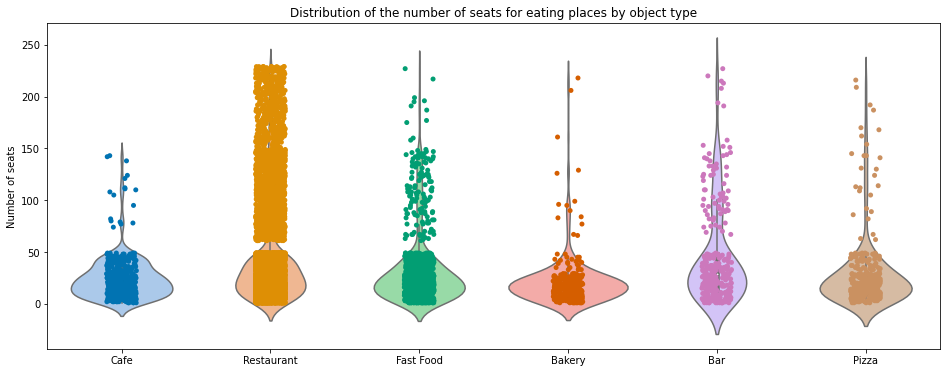

In [38]:
plt.figure(figsize=(16, 6))
sns.violinplot(x="object_type", y="number", data=rest_data, palette='pastel')
sns.stripplot(x="object_type", y="number", data=rest_data, palette='colorblind')
plt.xlabel("")
plt.ylabel("Number of seats")
plt.title("Distribution of the number of seats for eating places by object type")
plt.show()

In [39]:
rest_data[rest_data['chain'] == True]['number'].iplot(kind='hist',
                         xTitle='Number of Seats', yTitle='Count',
                          title='Distribution of the number of seats for eating places in chains',
                          color = '#6e7f29',
                          bins = 40)

In [40]:
rest_data[rest_data['chain'] == False]['number'].iplot(kind='hist',
                         xTitle='Number of Seats', yTitle='Count',
                          title='Distribution of the number of seats for independent eating places',
                          color = '#e7b300',
                          bins = 40)

The distributiuon of the seat number cannot be called normal in any case, there is a long tail above 50 seats, especially for restaurants. The data seems to be completelly artificial: the distributions for chained objects and independent places are almost identical.

[Back to Content](#content)

### Summary on the dataset

1. A quick check of missing values was performed, 3 data points fixed.
2. The `chain` variable was casted into boolean.
3. We have investigated implicit duplicates using stemming and dropped 57 objects at 47 addresses to fix the issue (still there can be some cases of similar titles with variations at the beginning of the title).
4. The resulting datasets contain data on 9594 eating places.
5. We have taken a look at the distribution of the seat number and learned that it is non-normal with long tail above 50 seats.

[Back to Content](#content)

Let's move on with the analysis.

# Data Analysis <a id='da'></a>

Let's paln the analysis. We are interested in looking into the following aspects:
- Investigate the proportions of the various types of establishments.
- Investigate the proportions of chain and nonchain establishments. Learn which type of establishment is typically a chain.
- Study what characterizes chains: many establishments with a small number of seats or a few establishments with a lot of seats?
- Determine the average (?) number of seats for each type of restaurant. On average, which type of restaurant has the greatest number of seats?
- Put the data on street names from the address column in a separate column. Study a graph of the top ten streets by number of restaurants.
- Find the number of streets that only have one restaurant.
- Learn trends for streets with a lot of restaurants, look at the distribution of the number of seats.
 

Let's deal with it one by one.

### Proportions of the various types of establishments

We have six types of establishments, thus horisontal bar chart can be employed; even a pie chart can be still relevant. Let's see the data first.

In [41]:
rest_data.head(1)

,id,object_name,address,chain,object_type,number
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26


In [42]:
pie_pivot = rest_data['object_type'].value_counts(normalize = True, ascending = True).reset_index()

In [43]:
pie_pivot['count'] = (len(rest_data) * pie_pivot['object_type']).astype('int')

In [44]:
pie_pivot

,index,object_type,count
0,Bakery,0.029289,281
1,Bar,0.030331,291
2,Pizza,0.033354,320
3,Cafe,0.045341,435
4,Fast Food,0.109860,1054
5,Restaurant,0.751824,7213


We can notice than appr. 75% of all the establishments are restaurants; thus, we can assume that a pie chart will look pretty ugly. Let's use a bar plot instead.

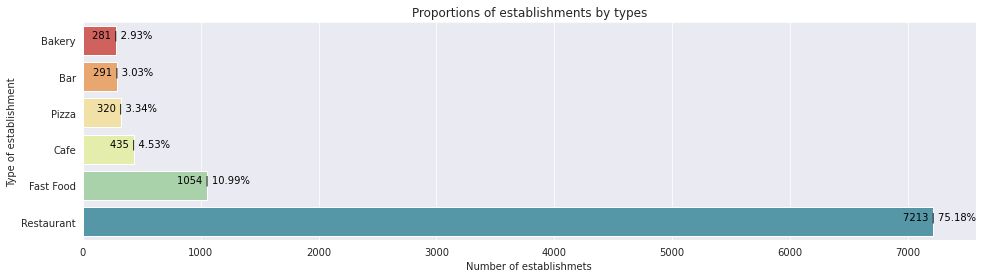

In [45]:
plt.figure(figsize=(16, 4))
sns.set_style('darkgrid')
sns.set_palette('Spectral')
sns.barplot(data=pie_pivot, x='count', y='index')
plt.title('Proportions of establishments by types')
plt.xlabel('Number of establishmets')
plt.ylabel('Type of establishment')

# Annotate bars with bar absolute values and proportions
for line in range(0,pie_pivot.shape[0]):
    plt.text(pie_pivot['count'].iloc[line] + 50,
            line,
            f"{pie_pivot['count'].iloc[line ]} | {(100*pie_pivot['object_type'].iloc[line]):.2f}%",
            horizontalalignment='center', verticalalignment = 'bottom',color='black',
            fontsize = 10)

plt.show()

[Back to Content](#content)

### Proportions of chain and non-chain establishments

Since we have significantly higher number of the establishments of one type out of six, to make the visualization look coherent, we should use a stacked bar chart.

In [46]:
stacked = rest_data.pivot_table(index = 'object_type',
                                columns = 'chain', values = 'number', aggfunc = 'count')

In [47]:
stacked['total'] = stacked.sum(axis = 1)

In [48]:
for col in stacked.columns:
    stacked[col] = stacked[col]*100/stacked['total']

In [49]:
stacked.drop(columns = ['total'], inplace = True)

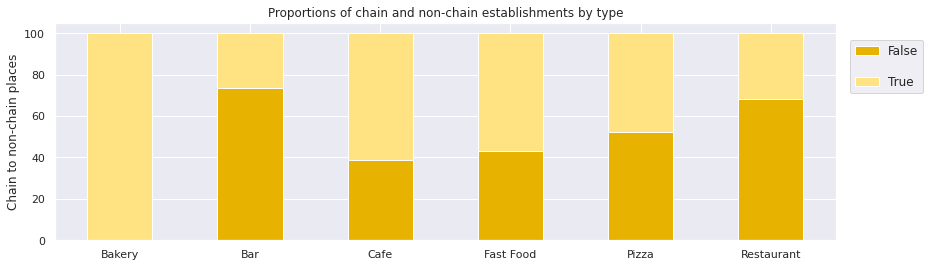

In [50]:
sns.set(rc={"figure.figsize":(14, 4)})

stacked.plot(kind='bar', stacked=True, color=['#e7b300', '#ffe282'])

plt.ylabel("Chain to non-chain places")
plt.xlabel("")
plt.title("Proportions of chain and non-chain establishments by type")


# Locate the legend poutside of the plot
plt.legend(bbox_to_anchor=(1.01, 0.95), loc='upper left', fontsize=12, labelspacing=1.5)

plt.xticks(rotation=0) # rotate the tick labels on the X axis 45 degrees


plt.show()

For some reason all the backeries work in chains. Than the majority of about 60% of cafes and fast food establishments work in chains. Pretty reasonably, bars are the most independent establishments with less than 30% of them working in chains.

[Back to Content](#content)

### Characteristics of chains

Let's look into chains.

In [51]:
chains = rest_data[rest_data['chain'] == True]

In [52]:
chains['number'].describe()

count    3653.000000
mean       39.648782
std        43.441745
min         1.000000
25%        13.000000
50%        25.000000
75%        44.000000
max       229.000000
Name: number, dtype: float64

We have in total 3653 establishments in chains with the median of 25 seats. In general we have already seen how different different types of establishement are; thus, we need to check out the seat distributions by types. To this end, box plots seem to fit most.

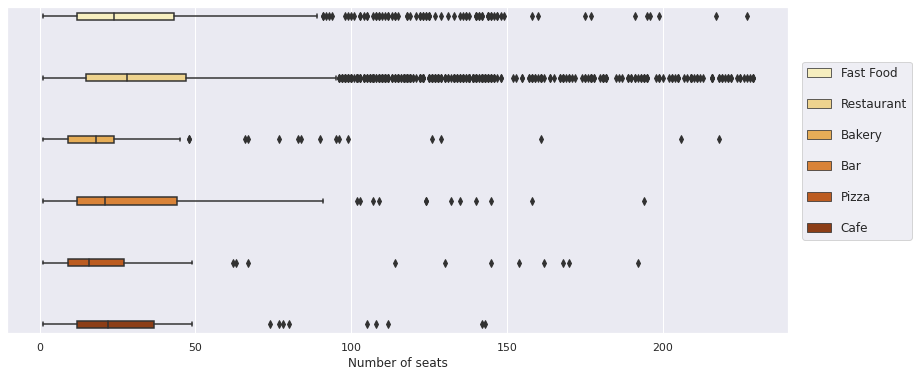

In [53]:
sns.set(rc={"figure.figsize":(14, 6)})
ag = sns.boxplot(y='object_type', x='number', hue='object_type', data=chains, orient="h",
                palette=sns.color_palette("YlOrBr"))

plt.legend(bbox_to_anchor=(1.01, 0.85), loc='upper left', fontsize=12, labelspacing=1.5)

ag.set(yticklabels=[])  
plt.ylabel("")
plt.xlabel("Number of seats")
plt.show()

Indeed, the distributions differ a lot, though five out of six types of establishments do have one characteristic in common: their distributions are skewed to the right, meaning that they have more objects with smaller number of seats, only backeries are in the opposite situation, they have relatively more objects with higher number of seats. All the types have medians below 25 seats, while restaurants have more seats in general (this is the reason why the whole dataset has the median value of 25).

[Back to Content](#content)

### Average number of seats for each type of establishment

Let's prepare some stats.

In [54]:
rest_stats = rest_data.pivot_table(index = 'object_type',
                                   columns = 'chain',
                                   values = 'number',
                                   aggfunc = ['count','median', 'mean', 'std'])

In [55]:
rest_stats.columns = [
            'Count\nIndependent object',
            'Count\nChain object',
            'Median\nIndependent object',
            'Median\nChain object',
            'Mean\nIndependent object',
            'Mean\nChain object',
            'STD\nIndependent object',
            'STD\nChain object']
    

Let's visualize tthese numbers.

In [56]:
def viz(df, fmt = '.0f', title = '',
               xlabel = "", ylabel = "", vmin = None, vmax = None):
    """
    A function which takes a cohort pivot table df and visualizes it as a heatmap.
    For more flexibility, it can take a rounding parameter fmt, and a title string.
    """
    plt.figure(figsize=(18, 4))
    plt.title(title)
    sns.heatmap(
        data = df, cmap="YlOrBr",
        annot=True,
        fmt=fmt,
        linewidths=2,
        linecolor='lightgray',
        vmin = vmin,
        vmax = vmax
    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

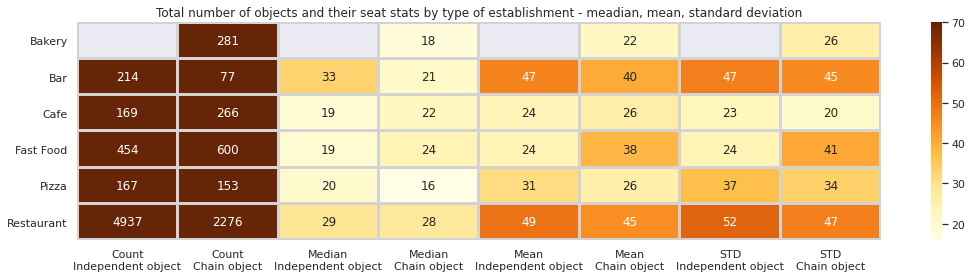

In [57]:
title = 'Total number of objects and their seat stats by type of establishment - meadian, mean, standard deviation'
viz(rest_stats, title = title, vmax = 70) # rescale the color scale to underline the stats on the seat number

Now we see that, in terms of the median, independent bars have more seats than any other type of establishment; while in terms of the average, independent restaurants have more seats; at the same moment,the value of standard deviation indicates that the difference between the numbers can be insignificant. Anyway, given the form of the distribution, which we have demonstrated above, we would have to employ a non-parametric test to check whether any difference between the distributions for bars and for restaurants takes place, such as the Wilcoxon-Mann-Whitney Non-parametric Test. Let's actually do a quick check, for the sake of curiosity:

In [58]:
samplea = rest_data[(rest_data['chain']==False) & (rest_data['object_type']=='Restaurant')]['number']
sampleb = rest_data[(rest_data['chain']==False) & (rest_data['object_type']=='Bar')]['number']

So, we have prepared the samples, now, let's formulate the null and the alternative hypotheses for testing:
1. The null hypothesis: there is no difference in the distributions of the two groups.
2. Alternative hypothesis: the distributions are different.
3. p-value: 0.05. We will reject the null hypothesis if the p-value is higher.

In [59]:
print("{0:.3f}".format(st.mannwhitneyu(samplea, sampleb)[1]))

0.846


Thus, the p-value is considerably higher than 0.05, so there's no reason to reject the null hypothesis and conclude that the two samples have different characteristics. We can actually conclude that independent bars and restaurants have the greatest number of seats, "on average", around 30. Let's make another quick check, calculate the exact share of chain restaurants in the dataset:


In [60]:
len(rest_data[(rest_data['object_type']=='Restaurant')
             & (rest_data['chain']== True)])/len(rest_data[rest_data['object_type']=='Restaurant'])

0.3155413836129211

For the presentation we will use a simplier version of this heatmap.

In [61]:
rest_stats = rest_data.pivot_table(index = 'object_type',
                                   columns = 'chain',
                                   values = 'number',
                                   aggfunc = ['count','median', 'mean'])

In [62]:
rest_stats.columns = [
            'Share\nIndependent object',
            'Share\nChain object',
            'Median\nIndependent object',
            'Median\nChain object',
            'Mean\nIndependent object',
            'Mean\nChain object']

In [63]:
rest_stats['total'] = (rest_stats['Share\nIndependent object'].fillna(0)
                                           +rest_stats['Share\nChain object'])

rest_stats['Share\nIndependent object'] = 100*rest_stats['Share\nIndependent object'].fillna(0) / rest_stats['total']
rest_stats['Share\nChain object'] = 100*rest_stats['Share\nChain object'] / rest_stats['total']
rest_stats.drop(columns = 'total', inplace = True)

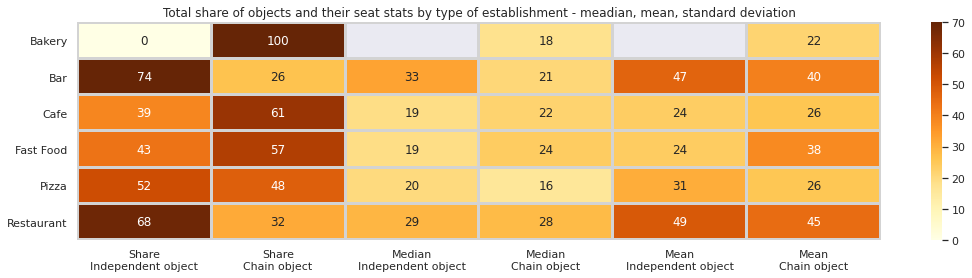

In [64]:
title = 'Total share of objects and their seat stats by type of establishment - meadian, mean, standard deviation'
viz(rest_stats, title = title, vmax = 70) # rescale the color scale to underline the stats on the seat number

[Back to Content](#content)

### Top ten streets by number of restaurants and the number of seets in them

Let's put the data on street names from the address column in a separate column and study the top ten streets by number of restaurants.

Let's recap how the addresses look like.

In [65]:
rest_data.head(20)

,id,object_name,address,chain,object_type,number
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20
5,11791,THE SPOT GRILL,10004 NATIONAL BLVD,False,Restaurant,14
6,11792,CPK,100 WORLD WAY # 126,False,Restaurant,100
7,11793,PHO LALA,3500 W 6TH ST STE 226,False,Restaurant,7
8,11794,ABC DONUTS,3027 N SAN FERNANDO RD UNIT 103,True,Fast Food,1
9,11795,UPSTAIRS,3707 N CAHUENGA BLVD,False,Restaurant,35


OK, we need to extract only the code in the beginning and letters (words) and drop the special sign `#`, numbers and `STE` and `UNIT` sign at the end. To this purose, we will define two short functions:

In [66]:
def r(lst):
    #drop the last item in a list if it is a number
    if lst[-1].isdigit():
        return lst[:-1]
    else:
        return lst

In [67]:
def p(lst):
    #drop the last item in a list if it is a number
    if lst[-1] == 'STE' or lst[-1] == 'UNIT':
        return lst[:-1]
    else:
        return lst

In [68]:
def j(lst):
    return " ".join(lst)

In [69]:
rest_data['street'] = rest_data['address'].replace('\#','', regex = True)

In [70]:
rest_data['street'] = rest_data['street'].str.split()

In [71]:
rest_data['street'] = rest_data['street'].apply(r).apply(p).apply(j)

In [72]:
rest_data.head(20)

,id,object_name,address,chain,object_type,number,street
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26,3708 N EAGLE ROCK BLVD
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9,100 WORLD WAY
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20,6801 HOLLYWOOD BLVD
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22,1814 W SUNSET BLVD
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20,2100 ECHO PARK AVE
5,11791,THE SPOT GRILL,10004 NATIONAL BLVD,False,Restaurant,14,10004 NATIONAL BLVD
6,11792,CPK,100 WORLD WAY # 126,False,Restaurant,100,100 WORLD WAY
7,11793,PHO LALA,3500 W 6TH ST STE 226,False,Restaurant,7,3500 W 6TH ST
8,11794,ABC DONUTS,3027 N SAN FERNANDO RD UNIT 103,True,Fast Food,1,3027 N SAN FERNANDO RD
9,11795,UPSTAIRS,3707 N CAHUENGA BLVD,False,Restaurant,35,3707 N CAHUENGA BLVD


Great, now we can calculate the TOP10 streets. First, we will count every type of esteblishment and then we will narrow it down to restaurants:

In [73]:
street_stats = rest_data['street'].value_counts()

In [74]:
street_stats.name = 'street_stats'

In [75]:
street_stats = pd.DataFrame(street_stats)

In [76]:
street_stats

,street_stats
6333 W 3RD ST,48
10250 SANTA MONICA BLVD,41
6801 HOLLYWOOD BLVD,29
928 S WESTERN AVE,26
3500 W 6TH ST,24
...,...
5009 MELROSE AVE,1
1822 W 7TH ST,1
9750 AIRPORT BLVD,1
4630 WHITTIER BLVD,1


Hm... Impressive, 48 objects on one street... Let's put it onto a plot.

In [77]:
street_stats[:10].iplot(kind='bar', color='orange',
                            xTitle='Street',
                        yTitle='Number of objects', title='TOP10 streets by the number of establishments')

Now, let's do the same for non-restaurants:

In [78]:
street_stats_other = rest_data[rest_data['object_type'] != 'Restaurant']['street'].value_counts()
street_stats_other.name = 'street_stats'
street_stats_other = pd.DataFrame(street_stats_other)
street_stats_other[:10].iplot(kind='bar', color='blue',
                            xTitle='Street',
                        yTitle='Number of objects', title='TOP10 streets by the number of non-restaurant establishments')

[Back to Content](#content)

### Streets that only have one restaurant

Let's make a quick check of how many of the total number of streets have only one restaurant.

In [79]:
street_stats_rest = rest_data[rest_data['object_type'] == 'Restaurant']['street'].value_counts()
street_stats_rest.name = 'street_stats'
street_stats_rest = pd.DataFrame(street_stats_other)

In [80]:
street_stats_rest['one_rest'] = np.where(street_stats_rest['street_stats']==1, True, False)
one_rest_streets = street_stats_rest[street_stats_rest['one_rest']==True].index.to_list()

In [81]:
len(one_rest_streets)

1901

There are 5135 out of 7478 streets (appr. 69%) which have only one establishment.

In [82]:
name = ['One establishment', 'More than one']
values = [len(one_rest_streets), len(street_stats) - len(one_rest_streets) ]

title = "Streets"
colors = ['gold', 'darkorange']

fig = go.Figure(data=[go.Pie(labels=name, values=values, title = title, hole=.6,
                            )])

fig.update_traces(textinfo='value + percent', textfont_size=20, marker=dict(colors=colors))

fig.show()

[Back to Content](#content)

### Trends for streets with large number of establishments

Let's extract a subset (we will call it `clusters`) of the intial dataframe with all the objects on the streets with 10 esteblishments and more:

In [83]:
street_stats['popular_street'] = np.where(street_stats['street_stats']>=10, True, False)

In [84]:
street_stats

,street_stats,popular_street
6333 W 3RD ST,48,True
10250 SANTA MONICA BLVD,41,True
6801 HOLLYWOOD BLVD,29,True
928 S WESTERN AVE,26,True
3500 W 6TH ST,24,True
...,...,...
5009 MELROSE AVE,1,False
1822 W 7TH ST,1,False
9750 AIRPORT BLVD,1,False
4630 WHITTIER BLVD,1,False


In [85]:
pop_streets = street_stats[street_stats['popular_street']==True].index.to_list()

In [86]:
#check
pop_streets[:10]

['6333 W 3RD ST',
 '10250 SANTA MONICA BLVD',
 '6801 HOLLYWOOD BLVD',
 '928 S WESTERN AVE',
 '3500 W 6TH ST',
 '735 S FIGUEROA ST',
 '3250 W OLYMPIC BLVD',
 '3425 E 1ST ST',
 '735 E 12TH ST',
 '333 S ALAMEDA ST']

In [87]:
clusters = rest_data.query('street in @pop_streets')

Let's apply a similar chain and seat number analysis as above.

In [88]:
cluster_stats = clusters.pivot_table(index = 'object_type',
                                   columns = 'chain',
                                   values = 'number',
                                   aggfunc = ['count','median', 'mean'])

In [89]:
cluster_stats.columns = [
            'Share\nIndependent object',
            'Share\nChain object',
            'Median\nIndependent object',
            'Median\nChain object',
            'Mean\nIndependent object',
            'Mean\nChain object']
    

In [90]:
cluster_stats['total'] = (cluster_stats['Share\nIndependent object'].fillna(0)
                                           +cluster_stats['Share\nChain object'])

cluster_stats['Share\nIndependent object'] = 100*cluster_stats['Share\nIndependent object'].fillna(0) / cluster_stats['total']
cluster_stats['Share\nChain object'] = 100*cluster_stats['Share\nChain object'] / cluster_stats['total']
cluster_stats.drop(columns = 'total', inplace = True)

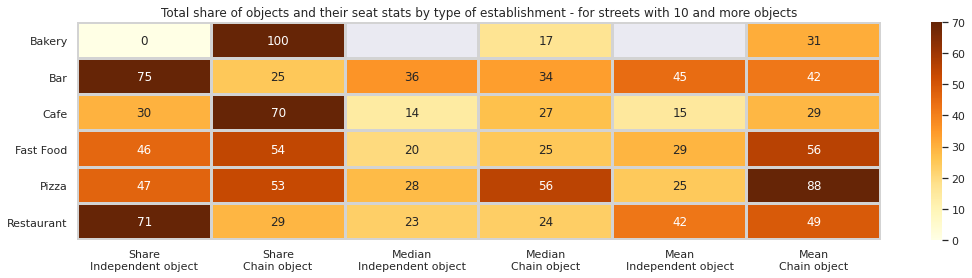

In [91]:
title = 'Total share of objects and their seat stats by type of establishment - for streets with 10 and more objects'
viz(cluster_stats, title = title, vmax = 70) # rescale the color scale to underline the stats on the seat number

Let's check the proportions for restaurants:

In [92]:
len(clusters[clusters['object_type']=='Restaurant']) / len(clusters)

0.7933723196881092

In [93]:
len(clusters[(clusters['object_type']=='Restaurant')
             & (clusters['chain']== True)])/len(clusters[clusters['object_type']=='Restaurant'])

0.28992628992628994

There aren't many objects in total for each group, 77% of the establishments on the popular streets are restaurants (does not seem to be a meaningful difference as compared to 75% in the initial dataset) and the share of the chain restaurants out of all restaurants is 29% (seems to be nonmeaninful difference as well as compared to 31.5% in the initial dataset).  50% of the restaurants on popular streets posess 24 and less seats (5-6 seats less than the whole dataset), while on average they have around 45 seats (similar to the initial dataset), meaning that the restaurants on the popular streets tend to be smaller, though large restaurants can have evenmore seats than those on the streets containing less restaurants (this can be due to the structure of property ownership and the real estate prices in popular areas).

One striking difference, as compared to the initial dataset, is the proportion of chain cafes and fast food objects and even pizza establishments. Once again, there is small number of objects of these types to draw statistically sound conclusions, but this can be a good marketing idea to focus on the niche of  fast-food like objects (eventually being a robo can be associated with a more efficient time utilization).

Another interesting observation is that those chain objects, especially chain pizzas, have higher number of seats than the general dataset. 

[Back to Content](#content)

# Conclusions <a id='conclusions'></a>

Me and my partners decided to open a small robot-run cafe in Los Angeles. The project is promising but expensive, so we want to try to attract investors. They are interested in the current market conditions—will we be able to maintain your success when the novelty of robot waiters wears off? So the task was to prepare a market research. To  this end, we employed open-source data on restaurants in LA.

While preprocessing the initial data:
1. A quick check of missing values was performed, 3 data points fixed.
2. The `chain` variable was casted into boolean.
3. We have investigated implicit duplicates using stemming and dropped 57 objects at 47 addresses to fix the issue (still there can be some cases of similar titles with variations at the beginning of the title).
4. The resulting datasets contain data on 9594 eating places.
5. We have taken a look at the distribution of the seat number and learned that it is non-normal with long tail above 50 seats.

Additionally, while performing the data analysis, we extracted the street names into a separate columns to study street-wise trends.

The analysis included the following aspects:
- Proportions of the various types of establishments.
- Proportions of chain and nonchain establishments. Learn which type of establishment is typically a chain.
- Characteristics of chains: many establishments with a small number of seats or a few establishments with a lot of seats?
- Number of seats for each type of establishment.
- TOP10 streets by number of restaurants.
- Share of streets that only have one restaurant.
- Trends for streets with a lot of restaurants.

Below are the main conclusions:
1. Appr. 75% of all the establishments are restaurants;
2. For some reason all the backeries work in chains. Than the majority of about 60% of cafes and fast food establishments work in chains. Pretty reasonably, bars are the most independent establishments with less than 30% of them working in chains, while appr. 30% of the restaurants are part of chains;
3. Chains tend to have many more objects with smaller number of seats, 50% of the objects possess 25 seats and less, while restaurants have more seats in general;
4. Independent bars and restaurants have the greatest number of seats, "on average", around 30;
5. The top10 streets with the largest amount of establishments in general are the same top10 streets with the largest amount of restaurants;
6. Appr. 86% of the streets have only one restaurant on them;
7. On the popular streets (with 10 and more restaurants) the distribution of the restaurants resempbles that of the general dataset; nevertheless, the restaurants on the popular streets tend to be smaller (50% of them possess 24 and less seats vs. 29-30 for the general dataset), though large restaurants can have evenmore seats than those on the streets containing less restaurants.
8. The most striking difference detected was in the proportion of chain cafes, general fast food objects, and even pizza establishments;
9. Another interesting observation is that those chain objects, especially chain pizzas, have higher number of seats than the general dataset.;
10. Unfortunatelly, data on only small number of such objects was available for popular streets; however, it gives a good value proposition idea on possible format: to focus on the niche of  fast-food like objects.



The overall recommendation on the restaurant type and number of seats would be to open a medium-size independent fast-food like object of 30 to 40 seats in one of the popular (to draw upon the traffic and raise interest at as many people as possible) streets. N.B. The real estate and the traffic issues, as well as the general readiness to accept the idea of robo-service in food, should be investigated additionally. After proving the concept, gathering some statistics and testing the hypotheses with regard to the target audience, menu and favorable conditions for a robo-restaurant to thrive, further developing of a chain can be assessed. Ultimately, the idea can become a new standard of high quality and time-efficient eating.

A PDF file is included to the project folder presenting this research to investors.

[Back to Content](#content)